In [1]:
import numpy as np              # numpy is a general-purpose math package
import yt                       # yt is the data vizualization package
from yt.units import *          # this lets you get things like speed of light in proper units just by typing 'c'
from astropy.table import Table # this is needed for reading in various foggie data byproducts
from astropy.io import ascii    # this too
import matplotlib.pyplot as plt # this is the standard python plotting package, very useful!
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import math
from ipynb.fs.defs.Original_frbprojection_code import frb_projection, projection
from scipy import optimize
import pwlf # A library for fitting continuous piecewise linear functions to data (Returns cut-off radius)
import os #for the lacie part 

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.foggie_load import *

foggie_dir = "/Users/hylee/foggie/foggie_sims/halo_008508/nref11c_nref9f/"
# code_path should be the path to the directory where you've cloned the github repo.
code_path = "/Users/hylee/coding/foggie/foggie/"

# Finally, this is the name of the simulation output.
foggie_dir_output = "/Users/hylee/foggie/foggie_output/halo_008508/nref11c_nref9f/"
foggie_sim = "/Users/hylee/foggie/foggie_sims/halo_008508/nref11c_nref9f/" #path that needs to be changed?/in the lacie
github_dir = "/Users/hylee/coding/foggie/foggie/" 
snap = "RD0042"
foggie_output = '/Users/hylee/foggie/foggie_output/halo_008508/nref11c_nref9f/' #KEEP UNCHAGED
track_dir = github_dir + 'halo_infos/008508/nref11c_nref9f/'
track_name = github_dir + 'halo_tracks/008508/nref11n_selfshield_15/halo_track_200kpc_nref9'
snap_name = foggie_sim + snap + '/' + snap
    
    

In [2]:
field = "density"
axis = "z" 
width = 200 #[kpc]
resolution = 70 #[pixel]
colorlabel = 'Density [log 10 g/cm^3]'
labelplot = 'Projected along y axis'
max_radius = width/2 #[kpc]
min_radius = 0  #[kpc]
binsize = 1.5 #[kpc]

In [3]:
#Defining function that converts each pixel into radius from galactic center by indexing /func1 

def radius_func(od, size, res):
    OD_Qua=[]
    OD_Rad=[]  #OD_Rad & OD_Met HAVE to be defined specifically inside func1/before for loop
    for i in range(70):
        for j in range(70):
            this_quantity_value = od[i][j]
            xindex = i
            yindex = j
            radius = (math.sqrt(((yindex-34)**2+(xindex-34)**2)))*(size/res)
            OD_Qua.append(this_quantity_value)
            OD_Rad.append(radius)
            
    return OD_Rad, OD_Qua

In [4]:
def binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize):
    index = 0 
    quantitylist = []
    sort = np.argsort(OD_Rad)
    sorted_radius = np.array(OD_Rad)[sort]
    sorted_quantity = np.array(OD_Qua)[sort]
    radiuslist = np.arange(min_radius, max_radius, binsize) + binsize/2
    while index < len(radiuslist):
        left_edge = index*binsize
        right_edge = left_edge + binsize 
        new_quantity = np.array(sorted_quantity)[(left_edge <= sorted_radius) & (sorted_radius < right_edge)]
        quantitylist.append((np.mean(new_quantity)))
        index +=1
    return radiuslist, quantitylist

In [5]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

In [6]:
ds, refine_box = foggie_load(snap_name, track_name, halo_c_v_name=track_dir + 'halo_c_v',
                             disk_relative=False, do_filter_particles=False, masses_dir=track_dir)

yt : [INFO     ] 2023-07-14 11:33:33,275 Parameters: current_time              = 639.44480357087
yt : [INFO     ] 2023-07-14 11:33:33,276 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-14 11:33:33,277 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-14 11:33:33,277 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-14 11:33:33,278 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-14 11:33:33,279 Parameters: current_redshift          = 0
yt : [INFO     ] 2023-07-14 11:33:33,280 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-14 11:33:33,281 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-14 11:33:33,281 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-14 11:33:33,282 Parameters: hubble_constant           = 0.695


Opening snapshot /Users/hylee/foggie/foggie_sims/halo_008508/nref11c_nref9f/RD0042/RD0042
get_refine_box: using this location:         col1          col2     col3     col4    col5     col6     col7  col8
------------------- -------- -------- ------- -------- -------- ------- ----
4.4408920985006e-16 0.488865 0.470316 0.50854 0.490865 0.472316 0.51054    9


Parsing Hierarchy : 100%|█████████████████| 4251/4251 [00:00<00:00, 8730.08it/s]
yt : [INFO     ] 2023-07-14 11:33:33,981 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


In [7]:
frb = frb_projection(ds, field, axis, refine_box, width, resolution, weight_field = None)
# How to tell which axis is y / z ? => By proj.plot()

yt : [INFO     ] 2023-07-14 11:33:44,444 Projection completed


In [8]:
frb.__dict__

{'data_source': YTQuadTreeProj (RD0042): , axis=2, field=[('gas', 'density')], weight_field=None,
 'ds': <weakproxy at 0x7fd192818540 to EnzoDataset at 0x7fd180780df0>,
 'bounds': (unyt_quantity(70382.02075547, 'kpc'),
  unyt_quantity(70582.02075547, 'kpc'),
  unyt_quantity(67698.01073692, 'kpc'),
  unyt_quantity(67898.01073692, 'kpc')),
 'buff_size': (70, 70),
 'antialias': True,
 'data': {},
 'axis': 2,
 'periodic': False,
 '_data_valid': False,
 '_filters': [],
 '_period': (unyt_quantity(0., 'code_length'),
  unyt_quantity(0., 'code_length')),
 '_edges': ((unyt_quantity(0., 'code_length'),
   unyt_quantity(1., 'code_length')),
  (unyt_quantity(0., 'code_length'), unyt_quantity(1., 'code_length')))}

In [9]:
OD_Rad, OD_Qua = radius_func(np.array(frb["gas",field]), width, resolution)

yt : [INFO     ] 2023-07-14 11:33:44,463 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


In [10]:
radiuslist, quantitylist =  binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize)

In [11]:
p , e = optimize.curve_fit(piecewise_linear, radiuslist, np.log10(quantitylist)) 
#p for popt (optimization parameter), e for pcov (covariance of popt)

xd = radiuslist

#plt.plot(xd, piecewise_linear(xd, *p)) #Plotting piecewise function / located in the cell below 

my_pwlf = pwlf.PiecewiseLinFit(radiuslist, np.log10(quantitylist))
breaks = my_pwlf.fit(2) #2 segments for this plot 
 
#print(breaks) => Prints the non-continuous point

In [16]:
print(p)

[ 3.00098622e+01 -4.38463244e+00 -9.39586366e-02 -5.95846693e-03]


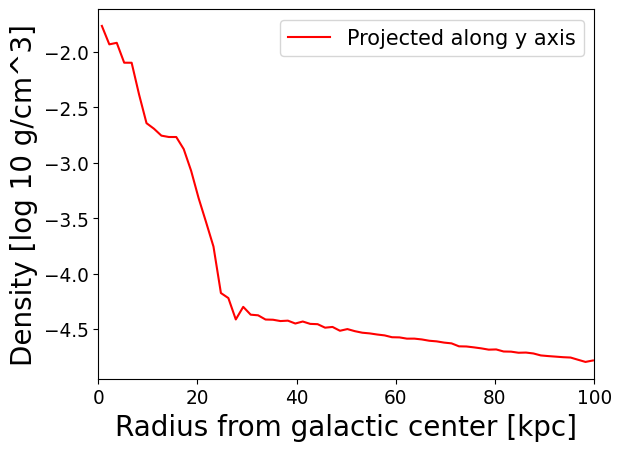

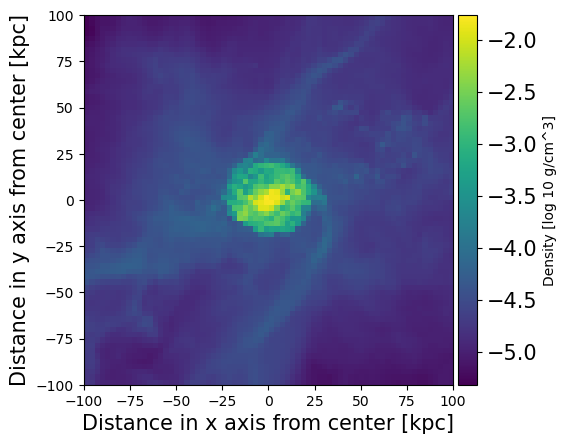

In [13]:
#Part I am trying to make into a function 

markersize = 10
fontsize = 20 
plotlabel = 'Projected along y axis'


# Make the part below as a function?
def plotting(xvalue, yvalue, color, label):
    fig1 = plt.figure()
    plt.plot(xvalue, yvalue, color, label=label)
    plt.legend(loc="upper right", fontsize = 15)
    plt.xlabel("Radius from galactic center [kpc]", fontsize = fontsize)
    plt.ylabel("Density [log 10 g/cm^3]", fontsize = fontsize)
    plt.xticks(fontsize = fontsize/1.5)
    plt.yticks(fontsize = fontsize/1.5)
    plt.xlim([min_radius, max_radius])
    return fig1


fig3 = plotting(radiuslist, np.log10(quantitylist), 'r-', plotlabel)
fig2 = projection(frb, field, width, colorlabel, axis, fontsize = 15)